In [1]:
# Copyright 2022 MIT 6.S191 Introduction to Deep Learning. All Rights Reserved.
# 
# Licensed under the MIT License. You may not use this file except in compliance
# with the License. Use and/or modification of this code outside of 6.S191 must
# reference:
#
# © MIT 6.S191: Introduction to Deep Learning
# http://introtodeeplearning.com

#Music Generation with RNNs
해당 페이지에서는 음악 생성을 위한 RNN 구축에 대해 알아보도록 하겠다.
우리는 ABC 표기법으로 원본 악보의 패턴을 학습할 수 있는 모델을 교육하고, 이 모델을 사용하여 새로운 음악을 생성하도록 해보자

##2.1 Dependencies

In [2]:
# Import Tensorflow 2.0
%tensorflow_version 2.x
import tensorflow as tf 

# Download and import the MIT 6.S191 package
!pip install mitdeeplearning
import mitdeeplearning as mdl

# Import all remaining packages
import numpy as np
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm
!apt-get install abcmidi timidity > /dev/null 2>&1

# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
assert len(tf.config.list_physical_devices('GPU')) > 0

     |████████████████████████████████| 2.1 MB 5.1 MB/s 
  Created wheel for mitdeeplearning: filename=mitdeeplearning-0.2.0-py3-none-any.whl size=2115442 sha256=7f6a7e0570258d257637f5091c6159f35ff1cae8c7c813831563bafa02aa3972
  Stored in directory: /root/.cache/pip/wheels/9a/b9/4f/99b7c8c5c75355550b83e1fcfc02956fb40c35eb01e2262877
Successfully built mitdeeplearning


##2.2 Dataset

In [3]:
# Dataset 다운로드. mit가 공부하기 쉽게 데이터 세트를 로드 해 두었음. 
songs = mdl.lab1.load_training_data() # 리스트 타입일듯??

# Print one of the songs to inspect it in greater detail!
example_song = songs[0]
print("\nExample song: ")
print(example_song)

Found 817 songs in text

Example song: 
X:1
T:Alexander's
Z: id:dc-hornpipe-1
M:C|
L:1/8
K:D Major
(3ABc|dAFA DFAd|fdcd FAdf|gfge fefd|(3efe (3dcB A2 (3ABc|!
dAFA DFAd|fdcd FAdf|gfge fefd|(3efe dc d2:|!
AG|FAdA FAdA|GBdB GBdB|Acec Acec|dfaf gecA|!
FAdA FAdA|GBdB GBdB|Aceg fefd|(3efe dc d2:|!


ABC 형태로 저장된 음악을 다시 원래의 음악으로 전환할 수 있다.

In [4]:
# Convert the ABC notation to audio file and listen to it
mdl.lab1.play_song(example_song)

Output hidden; open in https://colab.research.google.com to view.

유의할 점은 해당 데이터에는 노래 제목, 키, 템포 같은 메타 정보가 포함되어 있다는 것이다. 이러한 것들이 어떻게 학습의 복잡성에 영향을 미치는지 확인해 볼 필요가 있다.

In [5]:
# Join our list of song strings into a single string containing all songs
songs_joined = "\n\n".join(songs) #구분자로 계속 이어 붙이는걸로 알고 있는데 이렇게 한 상태로 

# Find all unique characters in the joined string
vocab = sorted(set(songs_joined))
print("There are", len(vocab), "unique characters in the dataset")

There are 83 unique characters in the dataset


##2.3 Process the dataset for the learning task
우리의 목표는 ABC 음악의 패턴을 학습하도록 RNN 모델을 교육하고, 이모델을 사용하여 새로운 음악을 생성, 예측하는 것입니다.

조금더 깊게 들어가면, 해당 모델이 수행해야할 작업은, 어떤 character 다음에 올 가능성이 가장 높은지를 찾게 하는것입니다.

이를 수행하기 위해서 우리는 해당 모델에 문자를 입력하고, 순차적인 시간의 흐름에 따라 다음  character를 예측하도록 훈련할 것입니다. RNN은 이전에 본 요소에 의존하는 내부 상태를 유지하므로, 주어진 순간까지 제공된 모든 문자에 대한 정보가 예측에 사용됩니다

###Vectorize the text
RNN 모델을 교육하기 전에 텍스트 기반 데이터 세트의 수치 표현을 만들어야 합니다. 이를 위해 문자를 숫자에 매핑하는 룩업 테이블과 숫자를 다시 문자에 매핑하는 룩업 테이블을 생성합니다. 우리가 본문에 있는 독특한 문자들을 확인했다는 것을 기억하라.

In [6]:
### Define numerical representation of text ###

# Create a mapping from character to unique index.
# For example, to get the index of the character "d", 
#   we can evaluate `char2idx["d"]`.  
char2idx = {u:i for i, u in enumerate(vocab)} #안에 존재하는 모든 단어들에 대해서 인덱스를 제공, 이를 딕셔너리 형태로 변환

# Create a mapping from indices to characters. This is
#   the inverse of char2idx and allows us to convert back
#   from unique index to the character in our vocabulary.
idx2char = np.array(vocab) ##>> index로 부터 다시 우리가 알 수 있는 형태로 변환 할 수 있게 해주는것

In [7]:
print('{')
for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '"' :   3,
  '#' :   4,
  "'" :   5,
  '(' :   6,
  ')' :   7,
  ',' :   8,
  '-' :   9,
  '.' :  10,
  '/' :  11,
  '0' :  12,
  '1' :  13,
  '2' :  14,
  '3' :  15,
  '4' :  16,
  '5' :  17,
  '6' :  18,
  '7' :  19,
  ...
}


In [8]:
### Vectorize the songs string ###

'''TODO: Write a function to convert the all songs string to a vectorized
    (i.e., numeric) representation. Use the appropriate mapping
    above to convert from vocab characters to the corresponding indices.

  NOTE: the output of the `vectorize_string` function 
  should be a np.array with `N` elements, where `N` is
  the number of characters in the input string
'''

def vectorize_string(string):
  return np.array([char2idx[char] for char in string]) # join으로 연결된 것을 한번에 다 묶어서 1차원 ndarray로 바꾸어 버린다. 

vectorized_songs = vectorize_string(songs_joined)




## Create training examples and targets
우리의 다음 단계는 실제로 텍스트를 훈련 중에 사용할 예제 순서로 나누는 것입니다. RNN에 입력하는 각 입력 시퀀스는 텍스트의 seq_length 문자를 포함합니다. 또한 각 입력 시퀀스에 대한 목표 시퀀스를 정의해야 하며, 이는 다음 문자를 예측하기 위한 RNN 교육에 사용됩니다. 각 입력에 대해 오른쪽으로 한 문자를 이동시킨 것을 제외하고 해당 대상은 동일한 길이의 텍스트를 포함합니다.

이렇게 하려면 텍스트를 seq_length+1의 청크로 나누겠습니다. seq_length가 4이고 우리의 텍스트가 "Hello"라고 가정하자. 그렇다면, 우리의 입력 수열은 "Hell"이고 목표 수열은 "ello"이다.

그런 다음 배치 방법을 사용하면 이 문자 인덱스 스트림을 원하는 크기의 시퀀스로 변환할 수 있습니다.

In [9]:
### Batch definition to create training examples ###

def get_batch(vectorized_songs, seq_length, batch_size):
  # the length of the vectorized songs string
  n = vectorized_songs.shape[0] - 1
  # randomly choose the starting indices for the examples in the training batch
  idx = np.random.choice(n-seq_length, batch_size)  #n-seq_length 보다 작은 정수중에 랜덤하게 batch_size만큼 만들어 놓는다.

  '''TODO: construct a list of input sequences for the training batch'''
  input_batch = [vectorized_songs[i : i+seq_length] for i in idx] #이게 뭔데 갑자기 이렇게 하는데?
  '''TODO: construct a list of output sequences for the training batch'''
  output_batch = [vectorized_songs[i+1 : i+seq_length+1] for i in idx] # 랜덤한 idx의 배열에 따라서, 해당 index 부터 batch크기 길이의 배열을 반환

  # x_batch, y_batch provide the true inputs and targets for network training
  x_batch = np.reshape(input_batch, [batch_size, seq_length]) # 테스트
  y_batch = np.reshape(output_batch, [batch_size, seq_length]) # 결과
  return x_batch, y_batch


# Perform some simple tests to make sure your batch function is working properly! 
test_args = (vectorized_songs, 10, 2)
if not mdl.lab1.test_batch_func_types(get_batch, test_args) or \
   not mdl.lab1.test_batch_func_shapes(get_batch, test_args) or \
   not mdl.lab1.test_batch_func_next_step(get_batch, test_args): 
   print("======\n[FAIL] could not pass tests")
else: 
   print("======\n[PASS] passed all tests!")

[PASS] test_batch_func_types
[PASS] test_batch_func_shapes
[PASS] test_batch_func_next_step
[PASS] passed all tests!


이러한 각 벡터에 대해 각 인덱스는 단일 시간 단계에서 처리됩니다. 따라서 0번 입력의 경우 모델은 시퀀스의 첫 번째 문자에 대한 인덱스를 수신하고 다음 문자의 인덱스를 예측하려고 합니다. 다음 시간 단계에서 동일한 작업을 수행하지만, RNN은 이전 단계의 정보, 즉 현재 입력 외에 업데이트된 상태를 고려한다.

본문의 처음 몇 문자에 대해 이것이 어떻게 작동하는지 살펴봄으로써 이것을 구체화할 수 있다.

In [10]:
x_batch, y_batch = get_batch(vectorized_songs, seq_length=5, batch_size=1)

for i, (input_idx, target_idx) in enumerate(zip(np.squeeze(x_batch), np.squeeze(y_batch))):
    print("Step {:3d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step   0
  input: 61 ('f')
  expected output: 82 ('|')
Step   1
  input: 82 ('|')
  expected output: 62 ('g')
Step   2
  input: 62 ('g')
  expected output: 61 ('f')
Step   3
  input: 61 ('f')
  expected output: 60 ('e')
Step   4
  input: 60 ('e')
  expected output: 1 (' ')


##2.4 The Recurrent Neural Network (RNN) model
이제 ABC 음악 데이터 세트에서 RNN 모델을 정의하고 교육한 다음 이 훈련된 모델을 사용하여 새로운 노래를 생성할 준비가 되었습니다. 이전 섹션에서 생성한 데이터 세트의 노래 스니펫 배치를 사용하여 RNN을 교육합니다.

이 모델은 state vector를 사용하여 연속 문자 간의 시간 관계에 대한 정보를 유지하는 LSTM 아키텍처를 기반으로 한다. 그런 다음 LSTM의 최종 출력은 fully connected Dense layer로 공급되며, 여기서 어휘의 각 문자에 대해 소프트맥스를 출력한 다음 이 분포에서 샘플을 추출하여 다음 문자를 예측합니다.

이 실험실의 첫 부분에서 소개했듯이 Keras API, 특히 TF.keras.Sequential를 사용할 것입니다. 세 개의 도면층이 모델을 정의하는 데 사용됩니다.

tf.keras.layers.Embedding:: 각 문자의 숫자를 medding_dimensions를 가진 벡터에 매핑하는 훈련 가능한 룩업 테이블로 구성된 입력 레이어이다.
tf.keras.layers.LSTM: LSTM 네트워크(크기 단위=rnn_유닛)
tf.keras.layers.Dense: vocab_size 출력이 있는 출력 계층입니다.
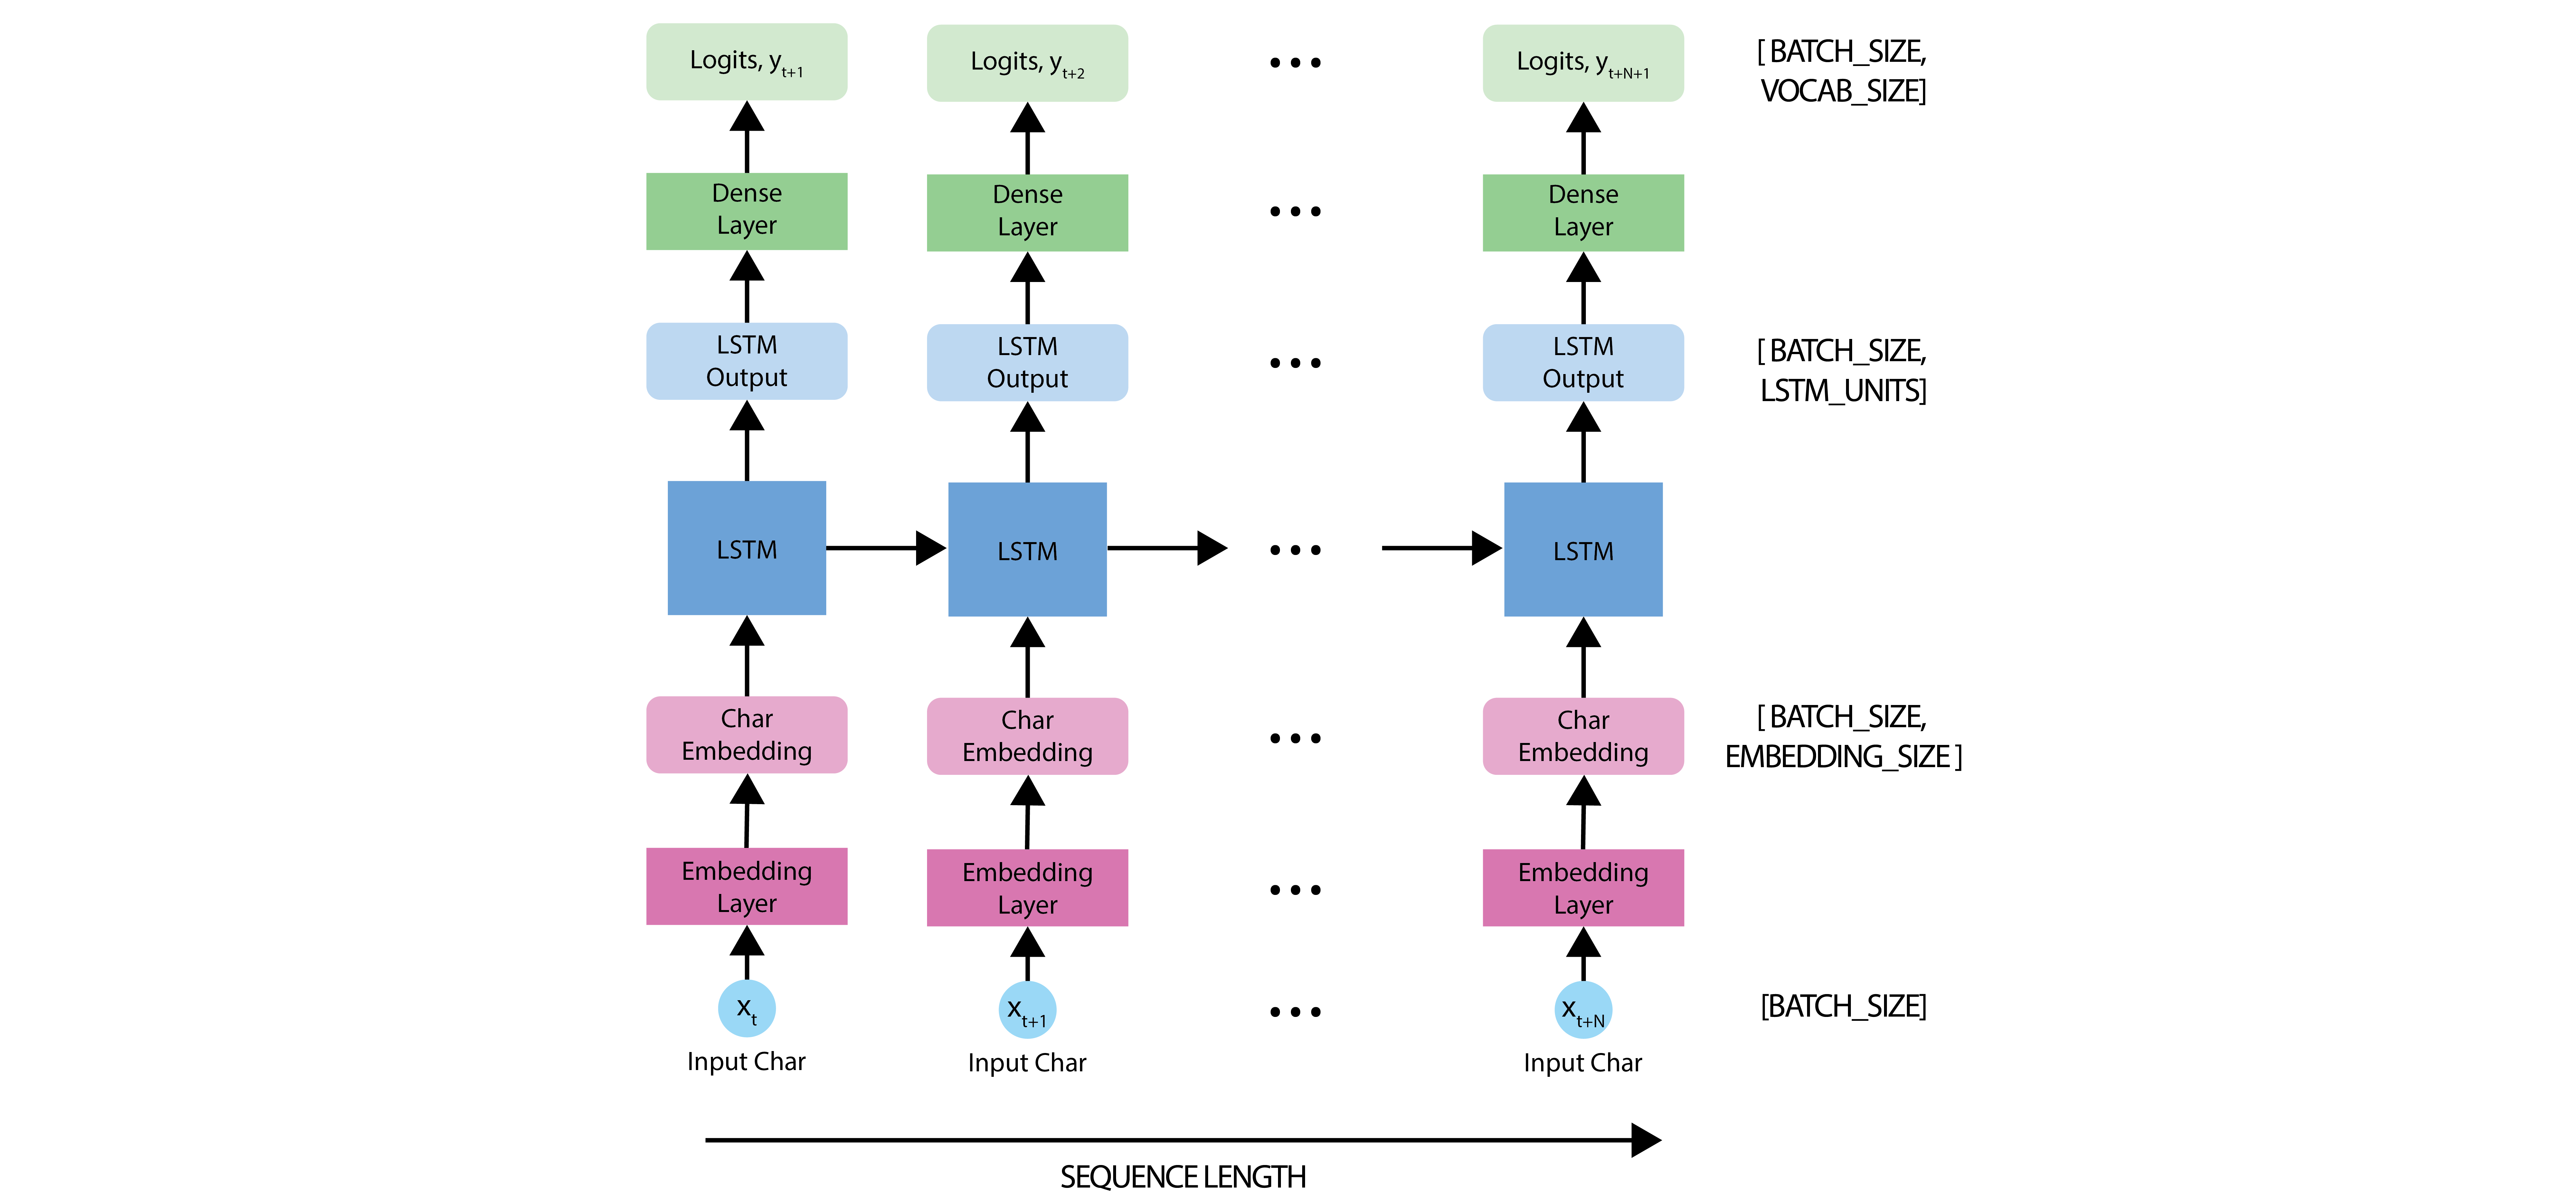

###Define the RNN model
Now, we will define a function that we will use to actually build the model.

In [11]:
def LSTM(rnn_units): 
  return tf.keras.layers.LSTM(
    rnn_units, 
    return_sequences=True, 
    recurrent_initializer='glorot_uniform',
    recurrent_activation='sigmoid',
    stateful=True,
  )

#여기서 부터 정신 맑을 때 다시한번 봐주는게 좋을것 같음!

In [12]:
### Defining the RNN Model ###

'''TODO: Add LSTM and Dense layers to define the RNN model using the Sequential API.'''
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    # Layer 1: Embedding layer to transform indices into dense vectors 
    #   of a fixed embedding size
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),

    # Layer 2: LSTM with `rnn_units` number of units. 
    # TODO: Call the LSTM function defined above to add this layer.
    LSTM(rnn_units),

    # Layer 3: Dense (fully-connected) layer that transforms the LSTM output
    #   into the vocabulary size. 
    # TODO: Add the Dense layer.
    tf.keras.layers.Dense(vocab_size)
  ])

  return model

# Build a simple model with default hyperparameters. You will get the 
#   chance to change these later.
model = build_model(len(vocab), embedding_dim=256, rnn_units=1024, batch_size=32)

###Test out the RNN model
모델이 예상대로 작동하는지 확인하기 위해 몇 가지 간단한 검사해 봅시다.
다음을 통해 모델의 layer, 각층의 output shape, 그리고 batch size를 확인 할 수 있습니다.

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (32, None, 256)           21248     
                                                                 
 lstm (LSTM)                 (32, None, 1024)          5246976   
                                                                 
 dense (Dense)               (32, None, 83)            85075     
                                                                 
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


In [14]:
x, y = get_batch(vectorized_songs, seq_length=100, batch_size=32)
pred = model(x)
print("Input shape:      ", x.shape, " # (batch_size, sequence_length)")
print("Prediction shape: ", pred.shape, "# (batch_size, sequence_length, vocab_size)")

Input shape:       (32, 100)  # (batch_size, sequence_length)
Prediction shape:  (32, 100, 83) # (batch_size, sequence_length, vocab_size)


### Predictions from the untrained model
해당 모델은 아직 훈련을 거치지 않았으므로, 지금은 단순히 확률 분포에 따른 표본을 추출한다. 

In [15]:
sampled_indices = tf.random.categorical(pred[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()
sampled_indices

array([53, 59, 29, 55, 68, 81,  0, 71, 17, 51, 82, 38, 47, 63, 43,  1, 18,
       62, 48, 82, 77, 62, 58, 37,  8, 44, 44, 48, 64, 40, 12, 32,  5,  4,
       19,  5, 68, 71, 47, 14, 46, 67, 28, 63, 62, 42, 71, 61,  5, 46,  1,
       14, 43, 77, 18, 72, 59, 43,  2, 19, 57, 25, 48, 14, 73, 62, 43, 77,
       13, 77, 52, 53, 69, 31,  2, 56,  9, 72, 38, 42, 13, 48, 75, 63, 54,
       66, 45, 75, 17, 30, 46, 82,  0, 25, 71, 10, 17, 23, 32, 79])

### 2.5 Training the model: loss and training operations
위와 같은 과정을 거치고 난 뒤, 해당 문제는 다음 character가 무엇이 올지 예측하는 표준 분류 문제와 유사하다. 

이 분류 작업을 훈련하기 위해서 crossentropy loss를 사용할 수 있다. 우리는 sparse_categorical_crossentropy loss를 사용할 것이다. 이 손실은 분류작업에 정수 대상을 활용하기 때문이다. 

In [16]:
### Defining the loss function ###

'''TODO: define the loss function to compute and return the loss between
    the true labels and predictions (logits). Set the argument from_logits=True.'''
def compute_loss(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True) # TODO
  return loss

'''TODO: compute the loss using the true next characters from the example batch 
    and the predictions from the untrained model several cells above'''
example_batch_loss = compute_loss(y,pred) # TODO y는 get_batch에서 구한 y값이고, pred는 모델에 이미 y가 정답인 data가 들어가 있는 상태이다

print("Prediction shape: ", pred.shape, " # (batch_size, sequence_length, vocab_size)") 
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (32, 100, 83)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.4193845


In [17]:
### Hyperparameter setting and optimization ###

# Optimization parameters:
num_training_iterations = 2000  # Increase this to train longer
batch_size = 4  # Experiment between 1 and 64
seq_length = 100  # Experiment between 50 and 500
learning_rate = 5e-3  # Experiment between 1e-5 and 1e-1

# Model parameters: 
vocab_size = len(vocab)
embedding_dim = 256 
rnn_units = 1024  # Experiment between 1 and 2048

# Checkpoint location: 
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

이제 학습을 진행할 optimizer와 횟수가 정해졌다. 앞으로 Adam과 Adagard를 사용해 볼 것입니다.

먼저 우리는 새로운 모델과 optimizer를 만들고, tf.GradientTape를 이용해서 backpropagation을 진행 할 것입니다.

또한 우리는 훈련과정에서 모델의 발전과정을 표시할 것이며, 손실이 최소화 되어가는 과정을 시각화 하도록 하겠습니다.

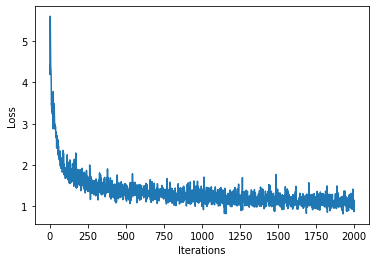

100%|██████████| 2000/2000 [03:26<00:00,  9.69it/s]


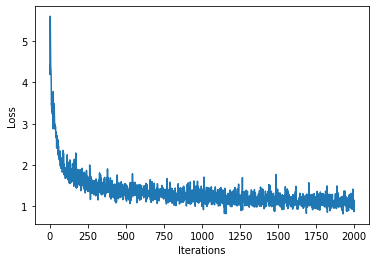

In [18]:
### Define optimizer and training operation ###

'''TODO: instantiate a new model for training using the `build_model`
  function and the hyperparameters created above.'''
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)

'''TODO: instantiate an optimizer with its learning rate.
  Checkout the tensorflow website for a list of supported optimizers.
  https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/
  Try using the Adam optimizer to start.'''
optimizer = tf.keras.optimizers.Adam(learning_rate)

@tf.function
def train_step(x, y): 
  # Use tf.GradientTape()
  with tf.GradientTape() as tape:
  
    '''TODO: feed the current input into the model and generate predictions'''
    y_hat = model(x)
  
    '''TODO: compute the loss!'''
    loss = compute_loss(y, y_hat)

  # Now, compute the gradients 
  '''TODO: complete the function call for gradient computation. 
      Remember that we want the gradient of the loss with respect all 
      of the model parameters. 
      HINT: use `model.trainable_variables` to get a list of all model
      parameters.'''
  grads = tape.gradient(loss, model.trainable_variables)
  
  # Apply the gradients to the optimizer so it can update the model accordingly
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss

##################
# Begin training!#
##################

history = []
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(num_training_iterations)):

  # Grab a batch and propagate it through the network
  x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size)
  loss = train_step(x_batch, y_batch)

  # Update the progress bar
  history.append(loss.numpy().mean())
  plotter.plot(history)

  # Update the model with the changed weights!
  if iter % 100 == 0:     
    model.save_weights(checkpoint_prefix)
    
# Save the trained model and the weights
model.save_weights(checkpoint_prefix)

##2.6 Generate music using the RNN model
이제 훈련된 RNN 모델을 이용하여 음악을 만들 수 있습니다. 음악을 생성하기 위해서는 seed를 제공해야한다.

일단 seed를 생성하고 나면, RNN을 사용하여 반복적으로 예측을 진행 할 수 있습니다. 

RNN이 연속적인 character를 통해서 softmax를 출력한다는 것을 기억하자. 추론을 위해서 sample에서 표본을 추출한 다음 생성된 노래를 ABC의 형식으로 인코딩한다.

우리는 인코딩 된 것을 적고, 들을 수 있다.
###Restore the latest checkpoint
추론을 단순하게 유지하기 위해서 우리는 1의 batch size를 사용할 것이다. 일단 설정하고 나면, 바꿀수 없다. 다른 batch size로 수행하길 원한다면 모델을 재작성하고, train중 마지막 체크 포인트 이후의 가중치를 복원하여야한다

In [19]:
'''TODO: Rebuild the model using a batch_size=1'''
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

# Restore the model weights for the last checkpoint after training
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (1, None, 256)            21248     
                                                                 
 lstm_2 (LSTM)               (1, None, 1024)           5246976   
                                                                 
 dense_2 (Dense)             (1, None, 83)             85075     
                                                                 
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


###The prediction procedure
이제 ABC 형식으로 음악을 만들어 보자

seed character와 RNN을 초기화 하고 생성할 문자의 수를 설정합니다.

seed character와 RNN을 이용하여 다음 예측 문자에 대한 확률 분포를 생성한다

Sample from multinomial distribution to calculate the index of the predicted character. This predicted character is then used as the next input to the model.

각 순차에서 업데이트된 RNN의 상태가 모델에 다시 공급되어 다음 예측을 수행할 때 더 많은 context를 가지게 된다. 

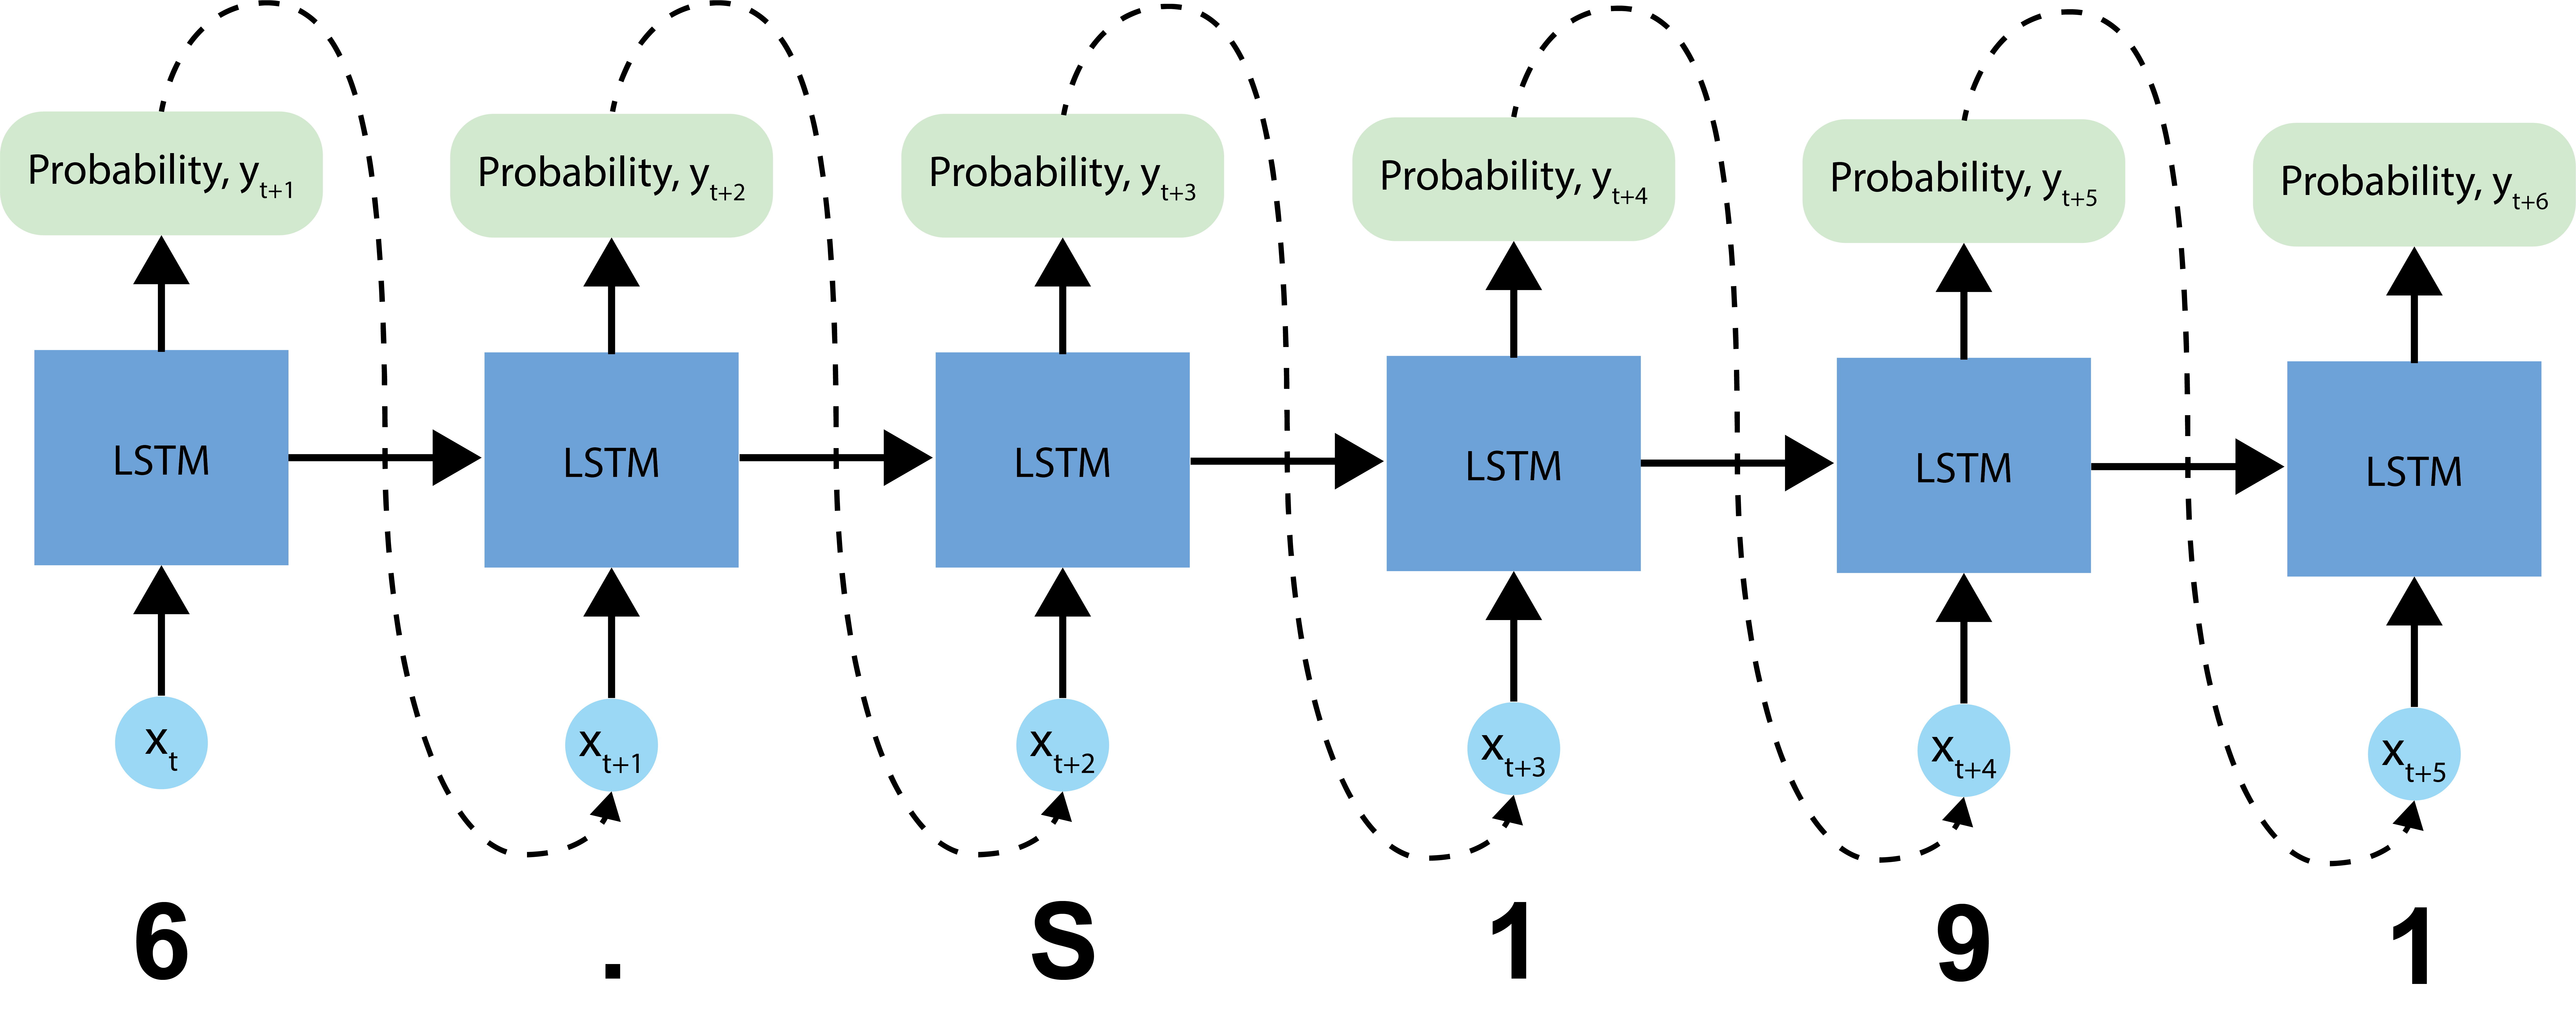

In [20]:
### Prediction of a generated song ###

def generate_text(model, start_string, generation_length=1000):
  # Evaluation step (generating ABC text using the learned RNN model)

  '''TODO: convert the start string to numbers (vectorize)'''
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Here batch size == 1
  model.reset_states()
  tqdm._instances.clear()

  for i in tqdm(range(generation_length)):
      '''TODO: evaluate the inputs and generate the next character predictions'''
      predictions = model(input_eval)
      
      # Remove the batch dimension
      predictions = tf.squeeze(predictions, 0)
      
      '''TODO: use a multinomial distribution to sample'''
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      
      # Pass the prediction along with the previous hidden state
      #   as the next inputs to the model
      input_eval = tf.expand_dims([predicted_id], 0)
      
      '''TODO: add the predicted character to the generated text!'''
      # Hint: consider what format the prediction is in vs. the output
      text_generated.append(idx2char[predicted_id])
    
  return (start_string + ''.join(text_generated))

In [22]:
'''TODO: Use the model and the function defined above to generate ABC format text of length 1000!
    As you may notice, ABC files start with "X" - this may be a good start string.'''
generated_text = generate_text(model, start_string="X", generation_length=1000) # TODO
# generated_text = generate_text('''TODO''', start_string="X", generation_length=1000)

### Play back generated songs ###

generated_songs = mdl.lab1.extract_song_snippet(generated_text)

for i, song in enumerate(generated_songs): 
  # Synthesize the waveform from a song
  waveform = mdl.lab1.play_song(song)

  # If its a valid song (correct syntax), lets play it! 
  if waveform:
    print("Generated song", i)
    ipythondisplay.display(waveform)

100%|██████████| 1000/1000 [00:10<00:00, 92.62it/s]


Found 2 songs in text
Generated song 1


2.7 Experiment and get awarded for the best songs!
Congrats on making your first sequence model in TensorFlow! It's a pretty big accomplishment, and hopefully you have some sweet tunes to show for it.

Consider how you may improve your model and what seems to be most important in terms of performance. Here are some ideas to get you started:

How does the number of training epochs affect the performance?
What if you alter or augment the dataset?
Does the choice of start string significantly affect the result?
Try to optimize your model and submit your best song! MIT students and affiliates will be eligible for prizes during the IAP offering. To enter the competition, MIT students and affiliates should upload the following to the course Canvas:

a recording of your song;
Jupyter notebook with the code you used to generate the song;
a description and/or diagram of the architecture and hyperparameters you used -- if there are any additional or interesting modifications you made to the template code, please include these in your description.